# STIPS Tutorial

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Introduction

**STIPS**, or the Space Telescope Imaging Product Simulator, is a tool developed by STScI for simulating observations of astronomical scenes with the Roman Wide Field Instrument (WFI). Detailed documentation of the tool is available on the [RDox pages](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stips-space-telescope-imaging-product-simulator). 

STIPS can generate images of the entire WFI array, which consists of 18 detectors, also called Sensor Chip Assemblies (SCAs). For more information on the WFI detectors and focal plane array please see the [RDox documentation](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/wfi-detectors). STIPS depends on the [Pandeia Exposure time calculator](https://roman-docs.stsci.edu/simulation-tools-handbook-home/roman-wfi-exposure-time-calculator/pandeia-for-roman) and the [STPSF point spread function (PSF) generator](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stpsf-for-roman) to create these simulations. Tutorial notebooks for both [Pandeia](../pandeia/pandeia.ipynb) and [STPSF](../stpsf/stpsf.ipynb) are also available. Users can choose to simulate between 1 and 18 SCAs in any of the WFI imaging filters, insert any number of point or extended sources, and specify a sky background estimate. STIPS will scale input fluxes to observed values, retrieve appropriate PSFs (interpolated to the positions of the sources), and add in additional noise terms.

As described in the [Caveats to Using STIPS for Roman](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stips-space-telescope-imaging-product-simulator/caveats-of-using-stips-for-roman), neither pixel saturation nor non-linearity residuals are currently supported.

This notebook is a starter guide to simulating and manipulating scenes with STIPS.

## Imports

Besides the STIPS-related imports, the `matplotlib` imports will help visualize simulated images and `astropy.io.fits` will help write a FITS table on the fly.

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import stips
import yaml

from astropy.io import fits
from stips.astro_image import AstroImage
from stips.observation_module import ObservationModule
from stips.scene_module import SceneModule

### Environment report

To verify the existing STIPS installation alongside its associated data files and dependencies, run the cell below. (Find the current software requirements [in the STIPS documentation](https://stips.readthedocs.io/en/latest/installation.html#stips-requirements).)

In [2]:
print(stips.__env__report__)

STIPS Version 2.3 with Data Version 1.0.10 at /home/runner/refdata/stips_data.
	STIPS Grid Generated with 1.1.0
Pandeia Version 2025.9 with Data Version 2025.9 at /home/runner/refdata/pandeia_data-2025.9-roman.
stpsf Version 2.1.0 with Data Version 2.1.0 at /home/runner/refdata/stpsf-data.



***

## Examples

### Basic STIPS Usage

This tutorial builds on the concepts introduced in the [STIPS Overview](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stips-space-telescope-imaging-product-simulator/overview-of-stips) article and is designed to walk through the phases of using STIPS at the most introductory level: creating a small scene, designing an observation, and generating a simulated image.

At its most fundamental level, STIPS takes a dictionary of observation and instrument parameters and a source catalog in order to return a simulated image. The source catalog can be either a user-defined input catalog in FITS format or it can be simulated using the STIPS `SceneModule` class (see below).

In this example, we start by specifying an **observation dictionary** for an image taken with the F129 filter, using the Detector 1 (WFI01), and with an exposure time of 300 seconds.

**Note:** We first need to update the path to the PSF cache using a YAML configuration file. A patch to fix the setting of this path in STIPS module calls will be released in the near future.

In [3]:
fix = {'psf_cache_location': os.environ["HOME"]}
with open('./stips_config.yaml', 'w') as file:
    yaml.dump(fix, file)

Now we set up the observation dictionary:

In [4]:
obs = {'instrument': 'WFI', 'filters': ['F129'], 'detectors': 1,
       'background': 'pandeia', 'observations_id': 42, 'exptime': 300,
       'offsets': [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 0.0,
                    'offset_dec': 0.0, 'offset_pa': 0.0}]
       }

Then we feed the dictionary to an instance of the `ObservationModule` class, while also specifying the central coordinates (90 degrees right ascension and 30 degrees declination) and position angle (0 degrees) as keyword arguments.

In [5]:
obm = ObservationModule(obs, ra=90, dec=30, pa=0, seed=42, cores=6)

2025-12-11 19:37:22,171 INFO: Got offsets as [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 0.0, 'offset_dec': 0.0, 'offset_pa': 0.0}]


2025-12-11 19:37:22,200 INFO: Adding observation with filter F129 and offset (0.0,0.0,0.0)


2025-12-11 19:37:22,201 INFO: Added 1 observations


2025-12-11 19:37:22,390 INFO: WFI with 1 detectors. Central offset (np.float64(2.065830864204697e-13), np.float64(-8.945310041616143e-14), 0)


#### Create a Simple Astronomical Scene

The other requirement is an input source catalog. In this case, we generate and input a user-defined catalog. STIPS accepts [several types of tables and catalogs](https://stips.readthedocs.io/en/latest/using_stips/catalogue_formats.html#stips-table-formats) in either the IPAC text or FITS BinTable format. This example uses a Mixed Catalog, which requires the following columns:

* `id`: Object ID
* `ra`: Right ascension (RA), in degrees
* `dec`: Declination (DEC), in degrees
* `flux`: Flux, in `units` (defined below)
* `type`: Approximation used to profile a source. Options are `'sersic'` (for extended sources) or `point`
* `n`: Sersic profile index
* `phi`: Position angle of the Sersic profle's major axis, in degrees
* `ratio`: Ratio of the Sersic profile's major and minor axes
  * Since `n`, `phi`, `ratio` only apply to extended sources, they are ignored in rows where `type` is set to `'point'`.
* `notes`: Optional per-source comments
* `units`: One of `‘p’` for photons/s, `‘e’` for electrons/s, `‘j’` for Jansky, or `‘c’` for counts/s

Below, we create a catalog containing two sources located near the central coordinates specified in the `ObservationModule`.

In [6]:
cols = [
    fits.Column(name='id', array=[1, 2], format='K'),
    fits.Column(name='ra', array=[90.02, 90.03], format='D'),
    fits.Column(name='dec', array=[29.98, 29.97], format='D'),
    fits.Column(name='flux', array=[0.00023, 0.0004], format='D'),
    fits.Column(name='type', array=['point', 'point'], format='8A'),
    fits.Column(name='n', array=[0, 0], format='D'),
    fits.Column(name='re', array=[0, 0], format='D'),
    fits.Column(name='phi', array=[0, 0], format='D'),
    fits.Column(name='ratio', array=[0, 0], format='D'),
    fits.Column(name='notes', array=['', ''], format='8A'),
    fits.Column(name='units', array=['j', 'j'], format='8A')
]

Next, we save the columns as a FITS table in the BinTable format and assign header keys that specify the filter and catalog type:

In [7]:
hdut = fits.BinTableHDU.from_columns(cols)
hdut.header['TYPE'] = 'mixed'
hdut.header['FILTER'] = 'F129'

And we save the catalog locally:

In [8]:
cat_file = 'catalog.fits'
hdut.writeto(cat_file, overwrite=True)

#### Simulate an Image

With the observation module and source catalog in tow, STIPS can take over the image simulation process. First, we trigger the initialization of a new observation:

In [9]:
obm.nextObservation()

2025-12-11 19:37:22,418 INFO: Initializing Observation 0 of 1


2025-12-11 19:37:22,418 INFO: Observation Filter is F129


2025-12-11 19:37:22,419 INFO: Observation (RA,DEC) = (90.0,30.0) with PA=0.0


2025-12-11 19:37:22,420 INFO: Resetting


2025-12-11 19:37:22,756 INFO: Returning background 0.6433085243497264 for 'pandeia'


2025-12-11 19:37:22,757 INFO: Creating Detector WFI01 with (RA,DEC,PA) = (90.0,30.0,0.0)


2025-12-11 19:37:22,757 INFO: Creating Detector WFI01 with offset (0.0,0.0)


2025-12-11 19:37:22,767 INFO: Creating Instrument with Configuration {'aperture': 'imaging', 'detector': 'wfi01', 'disperser': None, 'filter': 'f129', 'instrument': 'wfi', 'mode': 'imaging'}


2025-12-11 19:37:22,797 INFO: WFI01: (RA, DEC, PA) := (90.0, 30.0, 0.0), detected as (90.0, 30.0, 0.0)


2025-12-11 19:37:22,798 INFO: Detector WFI01 created


2025-12-11 19:37:22,798 INFO: Reset Instrument


Creating pandeia instrument roman.wfi.imaging


0

Next, we simulate an image containing the sources from the catalog we created earlier. Then, we add error residuals to the image:

In [10]:
cat_name = obm.addCatalogue(cat_file)

2025-12-11 19:37:22,806 INFO: Running catalogue catalog.fits


2025-12-11 19:37:22,806 INFO: Adding catalogue catalog.fits


2025-12-11 19:37:22,814 INFO: Converting mixed catalogue


2025-12-11 19:37:22,815 INFO: Preparing output table


2025-12-11 19:37:22,829 INFO: Converting chunk 2


2025-12-11 19:37:22,837 INFO: Finished converting catalogue to internal format


2025-12-11 19:37:22,838 INFO: Adding catalogue to detector WFI01


2025-12-11 19:37:22,838 INFO: Adding catalogue catalog_42_conv_F129.fits to AstroImage WFI01


2025-12-11 19:37:22,857 INFO: Determining pixel co-ordinates


2025-12-11 19:37:22,858 INFO: Keeping 2 items


2025-12-11 19:37:22,859 INFO: Writing 2 stars


2025-12-11 19:37:22,859 INFO: Adding 2 point sources to AstroImage WFI01


2025-12-11 19:37:22,865 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:22,866 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:23,677 INFO: Adding point source 1 to AstroImage 2631.9672457028046,1410.503966182148


2025-12-11 19:37:23,688 INFO: Adding point source 2 to AstroImage 2915.5365753799083,1083.2929624680437


2025-12-11 19:37:23,710 INFO: Added catalogue catalog_42_conv_F129.fits to AstroImage WFI01


2025-12-11 19:37:23,711 INFO: Finished catalogue catalog.fits


In [11]:
obm.addError()

2025-12-11 19:37:23,716 INFO: Adding Error


2025-12-11 19:37:23,716 INFO: Adding residual error


2025-12-11 19:37:23,745 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:37:23,983 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:37:23,984 INFO: Created AstroImage WFI01 and imported data from FITS file err_flat_wfi.fits


2025-12-11 19:37:24,013 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:37:24,247 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:37:24,248 INFO: Created AstroImage WFI01 and imported data from FITS file err_rdrk_wfi.fits


2025-12-11 19:37:24,252 INFO: Adding error to detector WFI01


2025-12-11 19:37:24,253 INFO: Adding background


2025-12-11 19:37:24,446 INFO: Returning background 0.6433085243497264 for 'pandeia'


2025-12-11 19:37:24,447 INFO: Background is 0.6433085243497264 counts/s/pixel


2025-12-11 19:37:24,628 INFO: Returning background 0.6433085243497264 for 'pandeia'


2025-12-11 19:37:24,628 INFO: Added background of 0.6433085243497264 counts/s/pixel


2025-12-11 19:37:24,675 INFO: Inserting correct exposure time


2025-12-11 19:37:24,679 INFO: Cropping Down to base Detector Size


2025-12-11 19:37:24,679 INFO: Cropping convolved image down to detector size


2025-12-11 19:37:24,680 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:37:24,691 INFO: WFI01: (RA, DEC, PA) := (90.0, 30.0, 0.0), detected as (90.0, 30.0, 0.0)


2025-12-11 19:37:24,695 INFO: Adding poisson noise


2025-12-11 19:37:25,156 INFO: Adding Poisson Noise with mean 0.0008605307221340754 and standard deviation 13.897467648762612


2025-12-11 19:37:25,158 INFO: Adding readnoise


2025-12-11 19:37:25,562 INFO: Adding readnoise with mean 0.0006565025541931391 and STDEV 12.00109577178955


2025-12-11 19:37:25,563 INFO: Adding flatfield residual


2025-12-11 19:37:25,600 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:37:25,601 INFO: Adding dark residual


2025-12-11 19:37:25,639 INFO: Adding Dark residual with mean 0.20807769894599915 and standard deviation 1.1006208658218384


2025-12-11 19:37:25,639 INFO: Adding cosmic ray residual


2025-12-11 19:37:26,601 INFO: Adding Cosmic Ray residual with mean 0.0847659632563591 and standard deviation 1.9229004383087158


2025-12-11 19:37:26,609 INFO: Finished adding error


2025-12-11 19:37:26,611 INFO: Finished Adding Error


We finish by saving the outputs to a FITS file. The `finalize()` method of the `ObservationModule` object can also return a full field of view mosaic and a list of the simulation's initial parameters.

In [12]:
fits_file_1, _, params_1 = obm.finalize(mosaic=False)
print(f"Output FITS file is {fits_file_1}")

2025-12-11 19:37:26,616 INFO: Converting to FITS file


2025-12-11 19:37:26,616 INFO: Converting detector WFI01 to FITS extension


2025-12-11 19:37:26,617 INFO: Creating Extension HDU from AstroImage WFI01


2025-12-11 19:37:26,619 INFO: Created Extension HDU from AstroImage WFI01


2025-12-11 19:37:26,680 INFO: Created FITS file /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/sim_42_0.fits


Output FITS file is /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/sim_42_0.fits


In [13]:
for prm in params_1:
    print(prm)

Instrument: WFI
Filters: F129
Pixel Scale: (0.110,0.110) arcsec/pix
Pivot Wavelength: 1.290 um
Background Type: Pandeia background rate
Exposure Time: 300.0s
Input Unit: counts/s
Added Flatfield Residual: True
Added Dark Current Residual: True
Added Cosmic Ray Residual: True
Added Readnoise: True
Added Poisson Noise: True
Detector X size: 4088
Detector Y size: 4088
Random Seed: 42


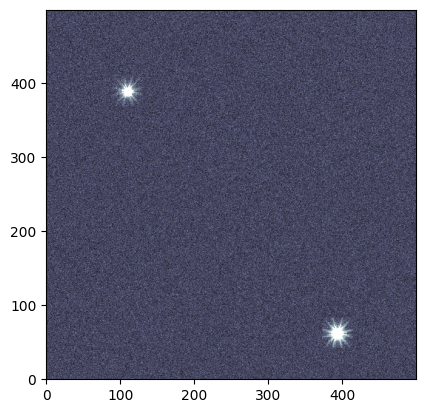

In [14]:
img_1 = fits.getdata(fits_file_1)[1000:1500, 2500:3000]

plt.imshow(img_1, vmax=1.5, origin='lower', cmap='bone')

### Generate Scenes Using STIPS Built-In Functions

STIPS can simulate scenes by importing pre-existing catalogs (as in the first example) or by using built-in functionality that generates collections of stars or galaxies based on user-specified parameters. Below, we will use the STIPS `SceneModule` to generate a stellar population and a galactic population.

First, we specify a set of parameters that will be used in both scenes (RA, DEC, ID) and initialize two `SceneModule` instances, one for the stellar population and one for the galaxy population:

In [15]:
obs_prefix_1 = 'notebook_example1'
obs_ra = 150.0
obs_dec = -2.5

scm_stellar = SceneModule(out_prefix=obs_prefix_1, ra=obs_ra, dec=obs_dec)
scm_galactic = SceneModule(out_prefix=obs_prefix_1, ra=obs_ra, dec=obs_dec)

Log level: INFO


Log level: INFO


#### Create a Stellar Population

Now we create a dictionary containing the parameters of the desired stellar population to pass to the `SceneModule` instance's `CreatePopulation()` method. The following parameters are needed to define a stellar population:

- Number of point sources
- Upper and lower limit of the age of the stars (in years)
- Upper and lower limit of the metallicity of the stars
- Initial Mass Function
- Binary fraction
- Clustering (True/False)
- Distribution type (Uniform, Inverse power-law)
- Total radius of the population
- Distance from the population
- Offset RA and DEC from the center of the scene being created

A full accounting of each dictionary entry's meaning can be found in the docstring of the `CreatePopulation()` method:

In [16]:
scm_stellar.CreatePopulation?

In [17]:
stellar_parameters = {'n_stars': 100, 'age_low': 7.5e12, 'age_high': 7.5e12,
                      'z_low': -2.0, 'z_high': -2.0, 'imf': 'salpeter',
                      'alpha': -2.35, 'binary_fraction': 0.1,
                      'distribution': 'invpow', 'clustered': True,
                      'radius': 100.0, 'radius_units': 'pc',
                      'distance_low': 20.0, 'distance_high': 20.0,
                      'offset_ra': 0.0, 'offset_dec': 0.0
                      }

We pass the dictionary to the stellar `SceneModule` instance's `CreatePopulation()` method. Running the method will save the newly-generated population locally.

In [18]:
stellar_cat_file = scm_stellar.CreatePopulation(stellar_parameters)
print(f"Stellar population saved to file {stellar_cat_file}")

2025-12-11 19:37:26,942 INFO: Creating catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:37:26,942 INFO: Creating age and metallicity numbers


2025-12-11 19:37:26,942 INFO: Created age and metallicity numbers


2025-12-11 19:37:26,943 INFO: Creating stars


2025-12-11 19:37:26,943 INFO: Age 1.35e+10


2025-12-11 19:37:26,944 INFO: Metallicity -2.000000


2025-12-11 19:37:26,945 INFO: Creating 100 stars


2025-12-11 19:37:27,250 INFO: Creating 100 objects, max radius 100.0, function invpow, scale 2.8


2025-12-11 19:37:27,304 INFO: Chunk 1: 106 stars


2025-12-11 19:37:27,316 INFO: Done creating catalogue


Stellar population saved to file /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


#### Create a Galactic Population

Repeat the population generation process, now by creating a dictionary containing parameters of a desired _galactic_ population. The following paramters are needed to define a galaxy population:

- Number of galaxies
- Upper and lower limit of the redshift
- Upper and lower limit of the galactic radii
- Range of V-band surface brightness magnitudes
- Clustering (True/False)
- Distribution type (Uniform, Inverse power-law)
- Radius of the distribution
- Offset RA and DEC from the center of the scene being created

A full accounting of each dictionary entry's meaning can be found in the docstring of the `CreateGalaxies()` method:

In [19]:
scm_galactic.CreateGalaxies?

We pass the dictionary to the galaxy `SceneModule` instance's `CreateGalaxies()` method, and save the result locally:

In [20]:
galaxy_parameters = {'n_gals': 10, 'z_low': 0.0, 'z_high': 0.2,
                     'rad_low': 0.01, 'rad_high': 2.0,
                     'sb_v_low': 30.0, 'sb_v_high': 25.0,
                     'distribution': 'uniform', 'clustered': False,
                     'radius': 200.0, 'radius_units': 'arcsec',
                     'offset_ra': 0.0, 'offset_dec': 0.0
                     }

In [21]:
galaxy_cat_file = scm_galactic.CreateGalaxies(galaxy_parameters)
print(f"Galaxy population saved to file {galaxy_cat_file}")

2025-12-11 19:37:27,331 INFO: Creating catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


2025-12-11 19:37:27,332 INFO: Wrote preamble


2025-12-11 19:37:27,332 INFO: Parameters are: {'n_gals': 10, 'z_low': 0.0, 'z_high': 0.2, 'rad_low': 0.01, 'rad_high': 2.0, 'sb_v_low': 30.0, 'sb_v_high': 25.0, 'distribution': 'uniform', 'clustered': False, 'radius': 200.0, 'radius_units': 'arcsec', 'offset_ra': 0.0, 'offset_dec': 0.0}


2025-12-11 19:37:27,334 INFO: Making Co-ordinates


2025-12-11 19:37:27,334 INFO: Creating 10 objects, max radius 200.0, function uniform, scale 2.8


2025-12-11 19:37:27,335 INFO: Converting Co-ordinates into RA,DEC


2025-12-11 19:37:27,345 INFO: Done creating catalogue


Galaxy population saved to file /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


#### Set up an Observation (First Pointing)

Once we've created a scene, we can use STIPS to simulate as many exposures of it in as many orientations as we'd like. In STIPS, a single telescope pointing is called an _offset_, and a collection of exposures is an _observation_.

We start this subsection by creating a single _offset_ that is dithered by 2 degrees in right ascension and rotated by 0.5 degrees in position angle from the center of the scene.

In [22]:
offset_1 = {'offset_id': 1, 'offset_centre': False,
            # True would center each detector on the same on-sky point
            'offset_ra': 2.0, 'offset_dec': 0.0, 'offset_pa': 0.5
            }

The offset information is contained within an _observation_ that is taken with the F129 filter, uses detectors WFI01 through WFI03, and has an exposure time of 1500 seconds. We also apply distortion and specify a sky background of 0.24 counts/s/pixel.

In [23]:
observation_parameters_1 = {'instrument': 'WFI', 'filters': ['F129'],
                            'detectors': 3, 'distortion': True,
                            'background': 0.24, 'observations_id': 1,
                            'exptime': 1500, 'offsets': [offset_1]
                            }

STIPS can also apply various types of error residuals to the observation. Here, we only include residuals from flat-fields and the dark current.

In [24]:
residuals_1 = {'residual_flat': True, 'residual_dark': True,
               'residual_cosmic': False, 'residual_poisson': False,
               'residual_readnoise': False
               }

Next, we feed the observation dictionary to an instance of the `ObservationModule` class, alongside the observation ID, right ascension, and declination specified earlier in this example.

In [25]:
obm_1 = ObservationModule(observation_parameters_1, residual=residuals_1,
                          out_prefix=obs_prefix_1, ra=obs_ra, dec=obs_dec)

2025-12-11 19:37:27,365 INFO: Got offsets as [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 2.0, 'offset_dec': 0.0, 'offset_pa': 0.5}]


2025-12-11 19:37:27,386 INFO: Adding observation with filter F129 and offset (2.0,0.0,0.5)


2025-12-11 19:37:27,386 INFO: Added 1 observations


2025-12-11 19:37:27,516 INFO: WFI with 3 detectors. Central offset (np.float64(1.7907664211548176e-13), np.float64(-8.945310041616143e-14), 0)


We call the `ObservationModule` object's `nextObservation()` method to move to the first offset/filter combination (`offset_1` and F129) contained in the object.

In [26]:
obm_1.nextObservation()

2025-12-11 19:37:27,521 INFO: Initializing Observation 0 of 1


2025-12-11 19:37:27,522 INFO: Observation Filter is F129


2025-12-11 19:37:27,522 INFO: Observation (RA,DEC) = (150.00055555555556,-2.5) with PA=0.5


2025-12-11 19:37:27,522 INFO: Resetting


2025-12-11 19:37:27,523 INFO: Returning background 0.24.


2025-12-11 19:37:27,523 INFO: Creating Detector WFI01 with (RA,DEC,PA) = (150.00055555555556,-2.5,0.5)


2025-12-11 19:37:27,525 INFO: Creating Detector WFI01 with offset (0.0,0.0)


2025-12-11 19:37:27,535 INFO: Creating Instrument with Configuration {'aperture': 'imaging', 'detector': 'wfi01', 'disperser': None, 'filter': 'f129', 'instrument': 'wfi', 'mode': 'imaging'}


Creating pandeia instrument roman.wfi.imaging


2025-12-11 19:37:27,566 INFO: WFI01: (RA, DEC, PA) := (150.00055555555556, -2.5, 0.5), detected as (150.00055555555556, -2.5, 0.5000000000001229)


2025-12-11 19:37:27,567 INFO: Detector WFI01 created


2025-12-11 19:37:27,567 INFO: Creating Detector WFI02 with (RA,DEC,PA) = (150.00063361633363,-2.6463679052675504,0.5)


2025-12-11 19:37:27,568 INFO: Creating Detector WFI02 with offset (7.806077806812047e-05,-0.1463679052675503)


2025-12-11 19:37:27,577 INFO: WFI02: (RA, DEC, PA) := (150.00063361633363, -2.6463679052675504, 0.5), detected as (150.00063361633363, -2.6463679052675504, 0.5000000000001229)


2025-12-11 19:37:27,578 INFO: Detector WFI02 created


2025-12-11 19:37:27,578 INFO: Creating Detector WFI03 with (RA,DEC,PA) = (150.00076976694686,-2.777285221181246,0.5)


2025-12-11 19:37:27,579 INFO: Creating Detector WFI03 with offset (0.00021421139128143576,-0.2772852211812461)


2025-12-11 19:37:27,588 INFO: WFI03: (RA, DEC, PA) := (150.00076976694686, -2.777285221181246, 0.5), detected as (150.00076976694686, -2.777285221181246, 0.5000000000001229)


2025-12-11 19:37:27,589 INFO: Detector WFI03 created


2025-12-11 19:37:27,589 INFO: Reset Instrument


0

Now that the observation is fully set up, we add the stellar and galactic populations to it. (Please note that each population may take about a minute to load.)

In [27]:
output_stellar_catalogs_1 = obm_1.addCatalogue(stellar_cat_file)
output_galaxy_catalogs_1 = obm_1.addCatalogue(galaxy_cat_file)
print(f"Output Catalogs are {output_stellar_catalogs_1} and "
      f"{output_galaxy_catalogs_1}.")

2025-12-11 19:37:27,595 INFO: Running catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:37:27,596 INFO: Adding catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:37:27,607 INFO: Converting phoenix catalogue


2025-12-11 19:37:27,607 INFO: Preparing output table


2025-12-11 19:37:27,626 INFO: Converting chunk 2


2025-12-11 19:37:27,627 INFO: Converting Phoenix Table to Internal format


2025-12-11 19:37:27,627 INFO: 1 datasets


2025-12-11 19:37:27,945 INFO: Finished converting catalogue to internal format


2025-12-11 19:37:27,945 INFO: Adding catalogue to detector WFI01


2025-12-11 19:37:27,946 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:37:27,965 INFO: Determining pixel co-ordinates


2025-12-11 19:37:27,966 INFO: Keeping 68 items


2025-12-11 19:37:27,967 INFO: Writing 68 stars


2025-12-11 19:37:27,967 INFO: Adding 68 point sources to AstroImage WFI01


2025-12-11 19:37:27,973 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:27,973 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:28,804 INFO: Adding point source 1 to AstroImage 2051.9592530481987,2094.064485517686


2025-12-11 19:37:28,815 INFO: Adding point source 2 to AstroImage 2063.5292969720063,2108.9634332180967


2025-12-11 19:37:28,827 INFO: Adding point source 3 to AstroImage 2008.4657206935929,2086.012070661093


2025-12-11 19:37:28,837 INFO: Adding point source 4 to AstroImage 2100.97814294416,2248.6458027895037


2025-12-11 19:37:28,849 INFO: Adding point source 5 to AstroImage 2191.293152297035,2175.7823819775813


2025-12-11 19:37:28,860 INFO: Adding point source 6 to AstroImage 2083.0380990589165,2127.3596638883623


2025-12-11 19:37:28,871 INFO: Adding point source 7 to AstroImage 2276.619646389378,1992.3611657061085


2025-12-11 19:37:28,882 INFO: Adding point source 8 to AstroImage 2001.6457518250488,2041.3978841733444


2025-12-11 19:37:28,894 INFO: Adding point source 9 to AstroImage 2046.836178495134,2065.1585094272887


2025-12-11 19:37:28,905 INFO: Adding point source 10 to AstroImage 2268.1366225519564,2034.119902433617


2025-12-11 19:37:28,916 INFO: Adding point source 11 to AstroImage 1851.3101816785643,2085.7610679210925


2025-12-11 19:37:28,927 INFO: Adding point source 12 to AstroImage 2286.79778068381,2297.663683503372


2025-12-11 19:37:28,938 INFO: Adding point source 13 to AstroImage 2415.4361879856833,1934.5172552160648


2025-12-11 19:37:28,949 INFO: Adding point source 14 to AstroImage 1629.5562614514035,2118.5885837011165


2025-12-11 19:37:28,960 INFO: Adding point source 15 to AstroImage 1891.625529262597,1658.0425796302811


2025-12-11 19:37:28,972 INFO: Adding point source 16 to AstroImage 2265.446758053793,1599.2745735503431


2025-12-11 19:37:28,983 INFO: Adding point source 17 to AstroImage 2607.3925747710437,2081.8311518837354


2025-12-11 19:37:28,994 INFO: Adding point source 18 to AstroImage 1767.1743138224438,1543.1138775130185


2025-12-11 19:37:29,005 INFO: Adding point source 19 to AstroImage 1787.6166661540942,2261.4106899545623


2025-12-11 19:37:29,016 INFO: Adding point source 20 to AstroImage 2055.4176391353717,2067.3447583100583


2025-12-11 19:37:29,027 INFO: Adding point source 21 to AstroImage 2210.7531833698167,2665.114986250673


2025-12-11 19:37:29,038 INFO: Adding point source 22 to AstroImage 1551.0663562681912,2043.605243848407


2025-12-11 19:37:29,050 INFO: Adding point source 23 to AstroImage 1748.6491115064064,2452.2532690529442


2025-12-11 19:37:29,061 INFO: Adding point source 24 to AstroImage 1420.8655635088307,1960.4703648118273


2025-12-11 19:37:29,072 INFO: Adding point source 25 to AstroImage 684.1752298675092,1750.5785949506335


2025-12-11 19:37:29,083 INFO: Adding point source 26 to AstroImage 1284.8114328773163,3289.5441323588084


2025-12-11 19:37:29,095 INFO: Adding point source 27 to AstroImage 1314.4733368099478,2620.4991313444984


2025-12-11 19:37:29,106 INFO: Adding point source 28 to AstroImage 3085.370600702894,1269.651617082362


2025-12-11 19:37:29,117 INFO: Adding point source 29 to AstroImage 2214.415513641475,3356.073580318342


2025-12-11 19:37:29,128 INFO: Adding point source 30 to AstroImage 1699.8869868040765,479.0362359771111


2025-12-11 19:37:29,140 INFO: Adding point source 31 to AstroImage 2514.496724457362,1295.77545192024


2025-12-11 19:37:29,151 INFO: Adding point source 32 to AstroImage 2408.5085135780255,397.4433648048839


2025-12-11 19:37:29,162 INFO: Adding point source 33 to AstroImage 1627.9563537016138,1283.3366167262259


2025-12-11 19:37:29,173 INFO: Adding point source 34 to AstroImage 936.5642241363157,1882.9557271753595


2025-12-11 19:37:29,184 INFO: Adding point source 35 to AstroImage 962.4366119100412,1452.0267104850045


2025-12-11 19:37:29,196 INFO: Adding point source 36 to AstroImage 1022.1815640687742,2371.1118113241346


2025-12-11 19:37:29,207 INFO: Adding point source 37 to AstroImage 3588.817757783024,3397.4738657086355


2025-12-11 19:37:29,218 INFO: Adding point source 38 to AstroImage 3289.312259363949,2664.385836726294


2025-12-11 19:37:29,229 INFO: Adding point source 39 to AstroImage 1109.6800177120324,3924.7653688008295


2025-12-11 19:37:29,241 INFO: Adding point source 40 to AstroImage 960.1443251338669,343.65338102728765


2025-12-11 19:37:29,252 INFO: Adding point source 41 to AstroImage 2633.089204594625,907.0201157815497


2025-12-11 19:37:29,263 INFO: Adding point source 42 to AstroImage 3930.9372496441483,2291.496735800102


2025-12-11 19:37:29,274 INFO: Adding point source 43 to AstroImage 2844.614488009348,1527.7395581399403


2025-12-11 19:37:29,285 INFO: Adding point source 44 to AstroImage 2946.8944025108685,2062.2045092620237


2025-12-11 19:37:29,296 INFO: Adding point source 45 to AstroImage 2889.236605946333,2118.4094473120117


2025-12-11 19:37:29,307 INFO: Adding point source 46 to AstroImage 371.1478973433234,2991.0352134788923


2025-12-11 19:37:29,319 INFO: Adding point source 47 to AstroImage 761.3504976478564,1886.9552523202656


2025-12-11 19:37:29,329 INFO: Adding point source 48 to AstroImage 658.6095893511908,2955.140039754186


2025-12-11 19:37:29,340 INFO: Adding point source 49 to AstroImage 1578.755270942256,2527.2750253404874


2025-12-11 19:37:29,352 INFO: Adding point source 50 to AstroImage 560.2225093956627,3118.9882099641627


2025-12-11 19:37:29,363 INFO: Adding point source 51 to AstroImage 2619.9410365974554,1773.3663128221324


2025-12-11 19:37:29,374 INFO: Adding point source 52 to AstroImage 2501.8478192705143,2169.236886700989


2025-12-11 19:37:29,385 INFO: Adding point source 53 to AstroImage 560.1859270163109,4020.800873377771


2025-12-11 19:37:29,396 INFO: Adding point source 54 to AstroImage 2290.629722404064,672.7040791453305


2025-12-11 19:37:29,407 INFO: Adding point source 55 to AstroImage 3460.842084657641,2506.213331221199


2025-12-11 19:37:29,418 INFO: Adding point source 56 to AstroImage 2067.18247151246,2136.64568964294


2025-12-11 19:37:29,429 INFO: Adding point source 57 to AstroImage 2630.756279957798,2517.181991700866


2025-12-11 19:37:29,440 INFO: Adding point source 58 to AstroImage 2511.051633999866,2063.285763742242


2025-12-11 19:37:29,451 INFO: Adding point source 59 to AstroImage 2069.135052290299,2644.2318929978805


2025-12-11 19:37:29,462 INFO: Adding point source 60 to AstroImage 2310.835921996443,2254.5200968256067


2025-12-11 19:37:29,473 INFO: Adding point source 61 to AstroImage 2380.973824245339,1928.3684472482753


2025-12-11 19:37:29,484 INFO: Adding point source 62 to AstroImage 127.53876968617101,2589.5071222990837


2025-12-11 19:37:29,496 INFO: Adding point source 63 to AstroImage 1755.565251987182,948.1805923721963


2025-12-11 19:37:29,507 INFO: Adding point source 64 to AstroImage 2563.8979823513864,3273.719636812945


2025-12-11 19:37:29,518 INFO: Adding point source 65 to AstroImage 2596.6224493045943,1100.4587065775504


2025-12-11 19:37:29,529 INFO: Adding point source 66 to AstroImage 3997.5957173452425,1954.9889631144767


2025-12-11 19:37:29,541 INFO: Adding point source 67 to AstroImage 3610.1309683316213,3983.774135570806


2025-12-11 19:37:29,552 INFO: Adding point source 68 to AstroImage 2498.554759955907,3989.444584566704


2025-12-11 19:37:29,576 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:37:29,576 INFO: Adding catalogue to detector WFI02


2025-12-11 19:37:29,577 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:37:29,599 INFO: Determining pixel co-ordinates


2025-12-11 19:37:29,600 INFO: Keeping 2 items


2025-12-11 19:37:29,601 INFO: Writing 2 stars


2025-12-11 19:37:29,601 INFO: Adding 2 point sources to AstroImage WFI02


2025-12-11 19:37:29,607 INFO: PSF File psf_WFI_2.3_F129_wfi02.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:29,608 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi02.fits


2025-12-11 19:37:30,443 INFO: Adding point source 1 to AstroImage 1468.8568861624813,4098.232361312826


2025-12-11 19:37:30,454 INFO: Adding point source 2 to AstroImage 504.74260462765915,3087.7087517314126


2025-12-11 19:37:30,478 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:37:30,478 INFO: Adding catalogue to detector WFI03


2025-12-11 19:37:30,479 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:37:30,491 INFO: Determining pixel co-ordinates


2025-12-11 19:37:30,492 INFO: Keeping 0 items


2025-12-11 19:37:30,493 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:37:30,494 INFO: Finished catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:37:30,494 INFO: Running catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


2025-12-11 19:37:30,495 INFO: Adding catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


2025-12-11 19:37:30,503 INFO: Converting bc95 catalogue


2025-12-11 19:37:30,504 INFO: Preparing output table


2025-12-11 19:37:30,519 INFO: Converting chunk 2


2025-12-11 19:37:30,520 INFO: Converting BC95 Catalogue


2025-12-11 19:37:30,520 INFO: Normalization Bandpass is johnson,v (<class 'str'>)


2025-12-11 19:37:30,521 INFO: Normalization Bandpass is johnson,v


2025-12-11 19:37:30,531 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,560 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,587 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,615 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,643 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,670 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,697 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,724 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,751 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,778 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:37:30,803 INFO: Finished converting catalogue to internal format


2025-12-11 19:37:30,804 INFO: Adding catalogue to detector WFI01


2025-12-11 19:37:30,804 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:37:30,824 INFO: Determining pixel co-ordinates


2025-12-11 19:37:30,825 INFO: Keeping 10 items


2025-12-11 19:37:30,826 INFO: Writing 10 galaxies


2025-12-11 19:37:30,826 INFO: Starting Sersic Profiles at Thu Dec 11 19:37:30 2025


2025-12-11 19:37:30,827 INFO: Index is 0


2025-12-11 19:37:33,854 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:33,855 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:36,798 INFO: Finished Galaxy 1 of 10


2025-12-11 19:37:36,799 INFO: Index is 1



Step 0 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9722 seconds, Running total: 5.9722 seconds


2025-12-11 19:37:39,855 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:39,856 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:42,774 INFO: Finished Galaxy 2 of 10


2025-12-11 19:37:42,775 INFO: Index is 2



Step 1 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9755 seconds, Running total: 11.9478 seconds


2025-12-11 19:37:45,806 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:45,807 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:48,694 INFO: Finished Galaxy 3 of 10


2025-12-11 19:37:48,695 INFO: Index is 3



Step 2 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9206 seconds, Running total: 17.8685 seconds


2025-12-11 19:37:51,728 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:51,729 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:37:54,633 INFO: Finished Galaxy 4 of 10


2025-12-11 19:37:54,634 INFO: Index is 4



Step 3 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9385 seconds, Running total: 23.8071 seconds


2025-12-11 19:37:57,258 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:37:57,258 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:00,154 INFO: Finished Galaxy 5 of 10


2025-12-11 19:38:00,155 INFO: Index is 5



Step 4 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.5208 seconds, Running total: 29.3280 seconds


2025-12-11 19:38:02,845 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:02,846 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:05,746 INFO: Finished Galaxy 6 of 10


2025-12-11 19:38:05,746 INFO: Index is 6



Step 5 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.5917 seconds, Running total: 34.9197 seconds


2025-12-11 19:38:08,796 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:08,797 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:11,700 INFO: Finished Galaxy 7 of 10


2025-12-11 19:38:11,701 INFO: Index is 7



Step 6 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9542 seconds, Running total: 40.8740 seconds


2025-12-11 19:38:14,757 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:14,757 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:17,663 INFO: Finished Galaxy 8 of 10


2025-12-11 19:38:17,664 INFO: Index is 8



Step 7 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9629 seconds, Running total: 46.8369 seconds


2025-12-11 19:38:20,719 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:20,720 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:23,649 INFO: Finished Galaxy 9 of 10


2025-12-11 19:38:23,650 INFO: Index is 9



Step 8 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9863 seconds, Running total: 52.8233 seconds


2025-12-11 19:38:26,714 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:26,715 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:29,578 INFO: Finished Galaxy 10 of 10


2025-12-11 19:38:29,579 INFO: Finishing Sersic Profiles at Thu Dec 11 19:38:29 2025


2025-12-11 19:38:29,592 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:38:29,592 INFO: Adding catalogue to detector WFI02


2025-12-11 19:38:29,593 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:38:29,606 INFO: Determining pixel co-ordinates


2025-12-11 19:38:29,606 INFO: Keeping 0 items


2025-12-11 19:38:29,608 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:38:29,608 INFO: Adding catalogue to detector WFI03


2025-12-11 19:38:29,609 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:38:29,621 INFO: Determining pixel co-ordinates


2025-12-11 19:38:29,622 INFO: Keeping 0 items


2025-12-11 19:38:29,624 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:38:29,624 INFO: Finished catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits



Step 9 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9290 seconds, Running total: 58.7523 seconds
Output Catalogs are ['/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI01.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI02.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI03.fits'] and ['/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F129.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F129_observed_WFI01.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F1

In [28]:
obm_1.addError()

2025-12-11 19:38:29,629 INFO: Adding Error


2025-12-11 19:38:29,630 INFO: Adding residual error


2025-12-11 19:38:29,658 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:38:29,899 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:38:29,900 INFO: Created AstroImage WFI01 and imported data from FITS file err_flat_wfi.fits


2025-12-11 19:38:29,929 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:38:30,165 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:38:30,166 INFO: Created AstroImage WFI01 and imported data from FITS file err_rdrk_wfi.fits


2025-12-11 19:38:30,170 INFO: Adding error to detector WFI01


2025-12-11 19:38:30,171 INFO: Adding background


2025-12-11 19:38:30,171 INFO: Returning background 0.24.


2025-12-11 19:38:30,171 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:38:30,172 INFO: Returning background 0.24.


2025-12-11 19:38:30,172 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:38:30,185 INFO: Inserting correct exposure time


2025-12-11 19:38:30,189 INFO: Cropping Down to base Detector Size


2025-12-11 19:38:30,190 INFO: Cropping convolved image down to detector size


2025-12-11 19:38:30,190 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:38:30,202 INFO: WFI01: (RA, DEC, PA) := (150.00055555555556, -2.5, 0.5000000000001229), detected as (150.00055555555556, -2.5, 0.5000000000001104)


2025-12-11 19:38:30,207 INFO: Adding flatfield residual


2025-12-11 19:38:30,245 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:38:30,246 INFO: Adding dark residual


2025-12-11 19:38:30,285 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:38:30,289 INFO: Adding error to detector WFI02


2025-12-11 19:38:30,290 INFO: Adding background


2025-12-11 19:38:30,290 INFO: Returning background 0.24.


2025-12-11 19:38:30,290 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:38:30,291 INFO: Returning background 0.24.


2025-12-11 19:38:30,291 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:38:30,334 INFO: Inserting correct exposure time


2025-12-11 19:38:30,338 INFO: Cropping Down to base Detector Size


2025-12-11 19:38:30,338 INFO: Cropping convolved image down to detector size


2025-12-11 19:38:30,339 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:38:30,350 INFO: WFI02: (RA, DEC, PA) := (150.00063361633363, -2.6463679052675504, 0.5000000000001229), detected as (150.00063361633363, -2.6463679052675504, 0.5000000000001104)


2025-12-11 19:38:30,355 INFO: Adding flatfield residual


2025-12-11 19:38:30,393 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:38:30,394 INFO: Adding dark residual


2025-12-11 19:38:30,433 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:38:30,437 INFO: Adding error to detector WFI03


2025-12-11 19:38:30,438 INFO: Adding background


2025-12-11 19:38:30,438 INFO: Returning background 0.24.


2025-12-11 19:38:30,438 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:38:30,439 INFO: Returning background 0.24.


2025-12-11 19:38:30,439 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:38:30,491 INFO: Inserting correct exposure time


2025-12-11 19:38:30,495 INFO: Cropping Down to base Detector Size


2025-12-11 19:38:30,496 INFO: Cropping convolved image down to detector size


2025-12-11 19:38:30,497 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:38:30,508 INFO: WFI03: (RA, DEC, PA) := (150.00076976694686, -2.777285221181246, 0.5000000000001229), detected as (150.00076976694686, -2.777285221181246, 0.5000000000001104)


2025-12-11 19:38:30,513 INFO: Adding flatfield residual


2025-12-11 19:38:30,551 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:38:30,552 INFO: Adding dark residual


2025-12-11 19:38:30,590 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:38:30,594 INFO: Finished adding error


2025-12-11 19:38:30,596 INFO: Finished Adding Error


As before, finish by saving the simulated image to a FITS file.

In [29]:
fits_file_1, _, params_1 = obm_1.finalize(mosaic=False)
print(f"Output FITS file is {fits_file_1}")

2025-12-11 19:38:30,601 INFO: Converting to FITS file


2025-12-11 19:38:30,602 INFO: Converting detector WFI01 to FITS extension


2025-12-11 19:38:30,602 INFO: Creating Extension HDU from AstroImage WFI01


2025-12-11 19:38:30,605 INFO: Created Extension HDU from AstroImage WFI01


2025-12-11 19:38:30,606 INFO: Converting detector WFI02 to FITS extension


2025-12-11 19:38:30,606 INFO: Creating Extension HDU from AstroImage WFI02


2025-12-11 19:38:30,608 INFO: Created Extension HDU from AstroImage WFI02


2025-12-11 19:38:30,609 INFO: Converting detector WFI03 to FITS extension


2025-12-11 19:38:30,610 INFO: Creating Extension HDU from AstroImage WFI03


2025-12-11 19:38:30,611 INFO: Created Extension HDU from AstroImage WFI03


2025-12-11 19:38:30,791 INFO: Created FITS file /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_1_0.fits


Output FITS file is /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_1_0.fits


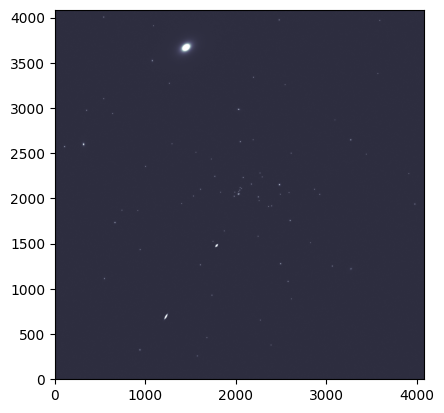

In [30]:
img_1 = fits.getdata(fits_file_1, ext=1)

plt.imshow(img_1, vmin=0.15, vmax=0.6, origin='lower', cmap='bone')

#### Modify an Observation (by Adding a Second Pointing)

To observe the same scene under different conditions, we make a new `ObservationModule` object that takes updated versions of the input observation parameter and residual dictionaries. The collection of resulting `ObservationModule` objects can be thought of as a dithered set of observations.

For the second observation, we assume an offset of 10 degrees in right ascension and rotated by 27 degrees in position angle from the center of the scene.

In [31]:
offset_2 = {'offset_id': 1, 'offset_centre': False,
            # True centers each detector on same point
            'offset_ra': 10.0, 'offset_dec': 0.0, 'offset_pa': 27
            }

The second observation is identical to the first (F129 filter, detectors WFI01 through WFI03, exposure time of 1500 seconds, distortion, and a sky background of 0.24 counts/s/pixel) with the exception of the offset parameters.

In [32]:
observation_parameters_2 = {'instrument': 'WFI', 'filters': ['F129'],
                            'detectors': 3, 'distortion': True,
                            'background': 0.24, 'observations_id': 1,
                            'exptime': 1500, 'offsets': [offset_2]
                            }

This time, we include residuals from the flat-field and read noise.

In [33]:
residuals_2 = {'residual_flat': True, 'residual_dark': False,
               'residual_cosmic': False, 'residual_poisson': False,
               'residual_readnoise': True
               }

We create the new `ObservationModule` object and initialize it for a simulation.

In [34]:
obs_prefix_2 = 'notebook_example2'
obm_2 = ObservationModule(observation_parameters_2, residuals=residuals_2,
                          out_prefix=obs_prefix_2, ra=obs_ra, dec=obs_dec)

2025-12-11 19:38:32,909 INFO: Got offsets as [{'offset_id': 1, 'offset_centre': False, 'offset_ra': 10.0, 'offset_dec': 0.0, 'offset_pa': 27}]


2025-12-11 19:38:32,939 INFO: Adding observation with filter F129 and offset (10.0,0.0,27)


2025-12-11 19:38:32,939 INFO: Added 1 observations


2025-12-11 19:38:33,069 INFO: WFI with 3 detectors. Central offset (np.float64(1.7907664211548176e-13), np.float64(-8.945310041616143e-14), 0)


In [35]:
obm_2.nextObservation()

2025-12-11 19:38:33,074 INFO: Initializing Observation 0 of 1


2025-12-11 19:38:33,075 INFO: Observation Filter is F129


2025-12-11 19:38:33,075 INFO: Observation (RA,DEC) = (150.00277777777777,-2.5) with PA=27.0


2025-12-11 19:38:33,076 INFO: Resetting


2025-12-11 19:38:33,076 INFO: Returning background 0.24.


2025-12-11 19:38:33,077 INFO: Creating Detector WFI01 with (RA,DEC,PA) = (150.00277777777777,-2.5,27.0)


2025-12-11 19:38:33,078 INFO: Creating Detector WFI01 with offset (0.0,0.0)


2025-12-11 19:38:33,089 INFO: Creating Instrument with Configuration {'aperture': 'imaging', 'detector': 'wfi01', 'disperser': None, 'filter': 'f129', 'instrument': 'wfi', 'mode': 'imaging'}


2025-12-11 19:38:33,119 INFO: WFI01: (RA, DEC, PA) := (150.00277777777777, -2.5, 27.0), detected as (150.00277777777777, -2.5, 27.000000000000913)


2025-12-11 19:38:33,120 INFO: Detector WFI01 created


2025-12-11 19:38:33,120 INFO: Creating Detector WFI02 with (RA,DEC,PA) = (150.00285583855583,-2.6463679052675504,27.0)


2025-12-11 19:38:33,121 INFO: Creating Detector WFI02 with offset (7.806077806812047e-05,-0.1463679052675503)


2025-12-11 19:38:33,130 INFO: WFI02: (RA, DEC, PA) := (150.00285583855583, -2.6463679052675504, 27.0), detected as (150.00285583855583, -2.6463679052675504, 27.000000000000913)


2025-12-11 19:38:33,131 INFO: Detector WFI02 created


2025-12-11 19:38:33,131 INFO: Creating Detector WFI03 with (RA,DEC,PA) = (150.00299198916906,-2.777285221181246,27.0)


2025-12-11 19:38:33,132 INFO: Creating Detector WFI03 with offset (0.00021421139128143576,-0.2772852211812461)


2025-12-11 19:38:33,142 INFO: WFI03: (RA, DEC, PA) := (150.00299198916906, -2.777285221181246, 27.0), detected as (150.00299198916906, -2.777285221181246, 27.000000000000913)


2025-12-11 19:38:33,142 INFO: Detector WFI03 created


2025-12-11 19:38:33,143 INFO: Reset Instrument


Creating pandeia instrument roman.wfi.imaging


0

Add the stellar and galactic populations to the new observation along with the sources of error chosen above.

In [36]:
output_stellar_catalogs_2 = obm_2.addCatalogue(stellar_cat_file)
output_galaxy_catalogs_2 = obm_2.addCatalogue(galaxy_cat_file)
print(f"Output Catalogs are {output_stellar_catalogs_2} and "
      f"{output_galaxy_catalogs_2}.")

2025-12-11 19:38:33,149 INFO: Running catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:38:33,150 INFO: Adding catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:38:33,160 INFO: Converting phoenix catalogue


2025-12-11 19:38:33,161 INFO: Preparing output table


2025-12-11 19:38:33,181 INFO: Converting chunk 2


2025-12-11 19:38:33,181 INFO: Converting Phoenix Table to Internal format


2025-12-11 19:38:33,182 INFO: 1 datasets


2025-12-11 19:38:33,497 INFO: Finished converting catalogue to internal format


2025-12-11 19:38:33,497 INFO: Adding catalogue to detector WFI01


2025-12-11 19:38:33,498 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:38:33,519 INFO: Determining pixel co-ordinates


2025-12-11 19:38:33,520 INFO: Keeping 70 items


2025-12-11 19:38:33,520 INFO: Writing 70 stars


2025-12-11 19:38:33,521 INFO: Adding 70 point sources to AstroImage WFI01


2025-12-11 19:38:33,527 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:33,527 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:34,332 INFO: Adding point source 1 to AstroImage 2001.5590167447203,2129.81557260575


2025-12-11 19:38:34,343 INFO: Adding point source 2 to AstroImage 2018.5613106964738,2137.986653317021


2025-12-11 19:38:34,355 INFO: Adding point source 3 to AstroImage 1959.0421694844104,2142.015837014853


2025-12-11 19:38:34,365 INFO: Adding point source 4 to AstroImage 2114.401354391386,2246.2837744824774


2025-12-11 19:38:34,377 INFO: Adding point source 5 to AstroImage 2162.716038858599,2140.777517452041


2025-12-11 19:38:34,388 INFO: Adding point source 6 to AstroImage 2044.2287528218064,2145.745330844443


2025-12-11 19:38:34,399 INFO: Adding point source 7 to AstroImage 2157.235846701601,1938.5550646565189


2025-12-11 19:38:34,410 INFO: Adding point source 8 to AstroImage 1933.0320548903424,2105.132079635419


2025-12-11 19:38:34,421 INFO: Adding point source 9 to AstroImage 1984.076457847524,2106.232496410012


2025-12-11 19:38:34,432 INFO: Adding point source 10 to AstroImage 2168.2766845424394,1979.7115182462671


2025-12-11 19:38:34,443 INFO: Adding point source 11 to AstroImage 1818.2861614114845,2211.9134262942434


2025-12-11 19:38:34,454 INFO: Adding point source 12 to AstroImage 2302.5694694711756,2207.239562130453


2025-12-11 19:38:34,465 INFO: Adding point source 13 to AstroImage 2255.657904738561,1824.8490919265112


2025-12-11 19:38:34,476 INFO: Adding point source 14 to AstroImage 1634.4783042572046,2340.237703313579


2025-12-11 19:38:34,487 INFO: Adding point source 15 to AstroImage 1663.5193747119042,1811.1445704453592


2025-12-11 19:38:34,499 INFO: Adding point source 16 to AstroImage 1971.8430546057355,1591.7533721306488


2025-12-11 19:38:34,510 INFO: Adding point source 17 to AstroImage 2493.177328236657,1871.0352423596826


2025-12-11 19:38:34,521 INFO: Adding point source 18 to AstroImage 1500.8628481358423,1763.8205097633445


2025-12-11 19:38:34,532 INFO: Adding point source 19 to AstroImage 1839.6588088132344,2397.528253534064


2025-12-11 19:38:34,543 INFO: Adding point source 20 to AstroImage 1992.7318045024767,2104.3600313239713


2025-12-11 19:38:34,554 INFO: Adding point source 21 to AstroImage 2398.4699005286943,2570.0154538628212


2025-12-11 19:38:34,565 INFO: Adding point source 22 to AstroImage 1530.777641266569,2308.1543845881806


2025-12-11 19:38:34,576 INFO: Adding point source 23 to AstroImage 1889.9386284636971,2585.7071596042274


2025-12-11 19:38:34,587 INFO: Adding point source 24 to AstroImage 1377.1619007840764,2291.849174178154


2025-12-11 19:38:34,598 INFO: Adding point source 25 to AstroImage 624.2188883669965,2432.7181664178474


2025-12-11 19:38:34,609 INFO: Adding point source 26 to AstroImage 1848.4300838742743,3541.990832707236


2025-12-11 19:38:34,620 INFO: Adding point source 27 to AstroImage 1576.4501556430655,2930.0039239597836


2025-12-11 19:38:34,631 INFO: Adding point source 28 to AstroImage 2558.5451399768785,930.9152509375376


2025-12-11 19:38:34,643 INFO: Adding point source 29 to AstroImage 2710.0506153464075,3186.744444233833


2025-12-11 19:38:34,654 INFO: Adding point source 30 to AstroImage 965.8575457889665,841.5634102249442


2025-12-11 19:38:34,665 INFO: Adding point source 31 to AstroImage 2059.3064300093424,1209.0161829396648


2025-12-11 19:38:34,676 INFO: Adding point source 32 to AstroImage 1563.6214088996635,452.3588026292289


2025-12-11 19:38:34,687 INFO: Adding point source 33 to AstroImage 1260.3601506093132,1593.455252653775


2025-12-11 19:38:34,698 INFO: Adding point source 34 to AstroImage 909.1568629896396,2438.572073810691


2025-12-11 19:38:34,709 INFO: Adding point source 35 to AstroImage 740.0320356709592,2041.3743908734536


2025-12-11 19:38:34,720 INFO: Adding point source 36 to AstroImage 1203.5922736629825,2837.2379639308792


2025-12-11 19:38:34,732 INFO: Adding point source 37 to AstroImage 3958.5240445980007,2610.5418048760293


2025-12-11 19:38:34,743 INFO: Adding point source 38 to AstroImage 3363.3849172692135,2088.113845195484


2025-12-11 19:38:34,754 INFO: Adding point source 39 to AstroImage 243.4284987807505,1050.4749630062015


2025-12-11 19:38:34,765 INFO: Adding point source 40 to AstroImage 1991.977813489255,808.1898618657672


2025-12-11 19:38:34,776 INFO: Adding point source 41 to AstroImage 3771.2158827419134,1468.11162149656


2025-12-11 19:38:34,788 INFO: Adding point source 42 to AstroImage 2458.241928549419,1269.311687983551


2025-12-11 19:38:34,799 INFO: Adding point source 43 to AstroImage 2788.252092297896,1701.9862160230336


2025-12-11 19:38:34,810 INFO: Adding point source 44 to AstroImage 2761.730542101335,1778.0126825497946


2025-12-11 19:38:34,821 INFO: Adding point source 45 to AstroImage 897.566888820123,3682.5180393196647


2025-12-11 19:38:34,833 INFO: Adding point source 46 to AstroImage 818.4142402134075,58.69352043107415


2025-12-11 19:38:34,844 INFO: Adding point source 47 to AstroImage 754.1365112300155,2520.3311091724945


2025-12-11 19:38:34,855 INFO: Adding point source 48 to AstroImage 3590.0167432112103,447.0584842415401


2025-12-11 19:38:34,866 INFO: Adding point source 49 to AstroImage 1138.8101719477902,3522.129830413646


2025-12-11 19:38:34,877 INFO: Adding point source 50 to AstroImage 1771.369092683112,2728.652770033859


2025-12-11 19:38:34,888 INFO: Adding point source 51 to AstroImage 1123.8685639240016,3712.663271732572


2025-12-11 19:38:34,899 INFO: Adding point source 52 to AstroImage 2366.771519015063,1589.3801515606326


2025-12-11 19:38:34,910 INFO: Adding point source 53 to AstroImage 2437.721737043403,1996.3513816223806


2025-12-11 19:38:34,921 INFO: Adding point source 54 to AstroImage 3605.7731994582646,3844.45022414836


2025-12-11 19:38:34,932 INFO: Adding point source 55 to AstroImage 1580.9478499728461,751.2963571452542


2025-12-11 19:38:34,943 INFO: Adding point source 56 to AstroImage 4002.6246283356127,673.2047526127178


2025-12-11 19:38:34,954 INFO: Adding point source 57 to AstroImage 3446.3169877961523,1870.0237484174365


2025-12-11 19:38:34,965 INFO: Adding point source 58 to AstroImage 2034.1823852582784,2161.130443747393


2025-12-11 19:38:34,976 INFO: Adding point source 59 to AstroImage 92.92409175074181,3834.081305975894


2025-12-11 19:38:34,987 INFO: Adding point source 60 to AstroImage 2708.338259463355,2250.2211940775815


2025-12-11 19:38:34,998 INFO: Adding point source 61 to AstroImage 2398.6835553487936,1897.4252938429531


2025-12-11 19:38:35,009 INFO: Adding point source 62 to AstroImage 2262.412903938523,2614.515927801918


2025-12-11 19:38:35,020 INFO: Adding point source 63 to AstroImage 2304.8315374157287,2157.9031218199316


2025-12-11 19:38:35,032 INFO: Adding point source 64 to AstroImage 2222.0727502247382,1834.7232866708177


2025-12-11 19:38:35,043 INFO: Adding point source 65 to AstroImage 500.3921556598939,3431.873939152217


2025-12-11 19:38:35,055 INFO: Adding point source 66 to AstroImage 1225.016459017171,1236.5737376570985


2025-12-11 19:38:35,066 INFO: Adding point source 67 to AstroImage 2986.0687168991712,2957.105218227983


2025-12-11 19:38:35,077 INFO: Adding point source 68 to AstroImage 2045.6540163172772,997.5761779235411


2025-12-11 19:38:35,088 INFO: Adding point source 69 to AstroImage 3680.722364562438,1137.2162510191388


2025-12-11 19:38:35,100 INFO: Adding point source 70 to AstroImage 3246.9445947574904,3626.7885077402134


2025-12-11 19:38:35,125 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:38:35,126 INFO: Adding catalogue to detector WFI02


2025-12-11 19:38:35,126 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:38:35,146 INFO: Determining pixel co-ordinates


2025-12-11 19:38:35,146 INFO: Keeping 1 items


2025-12-11 19:38:35,148 INFO: Writing 1 stars


2025-12-11 19:38:35,148 INFO: Adding 1 point sources to AstroImage WFI02


2025-12-11 19:38:35,154 INFO: PSF File psf_WFI_2.3_F129_wfi02.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:35,154 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi02.fits


2025-12-11 19:38:35,980 INFO: Adding point source 1 to AstroImage 1060.2681380772267,3709.421233050434


2025-12-11 19:38:36,004 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:38:36,004 INFO: Adding catalogue to detector WFI03


2025-12-11 19:38:36,005 INFO: Adding catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:38:36,018 INFO: Determining pixel co-ordinates


2025-12-11 19:38:36,018 INFO: Keeping 0 items


2025-12-11 19:38:36,020 INFO: Added catalogue notebook_example1_stars_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:38:36,020 INFO: Finished catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000.fits


2025-12-11 19:38:36,021 INFO: Running catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


2025-12-11 19:38:36,021 INFO: Adding catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits


2025-12-11 19:38:36,029 INFO: Converting bc95 catalogue


2025-12-11 19:38:36,030 INFO: Preparing output table


2025-12-11 19:38:36,045 INFO: Converting chunk 2


2025-12-11 19:38:36,045 INFO: Converting BC95 Catalogue


2025-12-11 19:38:36,046 INFO: Normalization Bandpass is johnson,v (<class 'str'>)


2025-12-11 19:38:36,046 INFO: Normalization Bandpass is johnson,v


2025-12-11 19:38:36,056 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,082 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,109 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,136 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,163 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,191 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,217 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,244 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,272 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,298 WARNING: DataConfigurationError: Error loading normalization bandpass: johnson_v EngineInputError("Invalid keys provided: ['johnson_v'] ('johnson_v')")


2025-12-11 19:38:36,328 INFO: Finished converting catalogue to internal format


2025-12-11 19:38:36,328 INFO: Adding catalogue to detector WFI01


2025-12-11 19:38:36,329 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:38:36,350 INFO: Determining pixel co-ordinates


2025-12-11 19:38:36,351 INFO: Keeping 10 items


2025-12-11 19:38:36,352 INFO: Writing 10 galaxies


2025-12-11 19:38:36,353 INFO: Starting Sersic Profiles at Thu Dec 11 19:38:36 2025


2025-12-11 19:38:36,353 INFO: Index is 0


2025-12-11 19:38:39,359 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:39,359 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:42,286 INFO: Finished Galaxy 1 of 10


2025-12-11 19:38:42,287 INFO: Index is 1



Step 0 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9337 seconds, Running total: 5.9338 seconds


2025-12-11 19:38:45,291 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:45,292 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:48,218 INFO: Finished Galaxy 2 of 10


2025-12-11 19:38:48,219 INFO: Index is 2



Step 1 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9323 seconds, Running total: 11.8661 seconds


2025-12-11 19:38:51,270 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:51,271 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:38:54,205 INFO: Finished Galaxy 3 of 10


2025-12-11 19:38:54,205 INFO: Index is 3



Step 2 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9861 seconds, Running total: 17.8522 seconds


2025-12-11 19:38:57,253 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:38:57,254 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:00,164 INFO: Finished Galaxy 4 of 10


2025-12-11 19:39:00,165 INFO: Index is 4



Step 3 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9595 seconds, Running total: 23.8118 seconds


2025-12-11 19:39:02,791 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:02,791 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:05,675 INFO: Finished Galaxy 5 of 10


2025-12-11 19:39:05,676 INFO: Index is 5



Step 4 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.5107 seconds, Running total: 29.3226 seconds


2025-12-11 19:39:08,334 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:08,334 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:11,224 INFO: Finished Galaxy 6 of 10


2025-12-11 19:39:11,224 INFO: Index is 6



Step 5 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.5487 seconds, Running total: 34.8713 seconds


2025-12-11 19:39:14,239 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:14,240 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:17,128 INFO: Finished Galaxy 7 of 10


2025-12-11 19:39:17,129 INFO: Index is 7



Step 6 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9043 seconds, Running total: 40.7757 seconds


2025-12-11 19:39:20,140 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:20,141 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:23,027 INFO: Finished Galaxy 8 of 10


2025-12-11 19:39:23,027 INFO: Index is 8



Step 7 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.8986 seconds, Running total: 46.6744 seconds


2025-12-11 19:39:26,071 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:26,071 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:28,954 INFO: Finished Galaxy 9 of 10


2025-12-11 19:39:28,955 INFO: Index is 9



Step 8 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9272 seconds, Running total: 52.6017 seconds


2025-12-11 19:39:31,993 INFO: PSF File psf_WFI_2.3_F129_wfi01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:31,993 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


2025-12-11 19:39:34,893 INFO: Finished Galaxy 10 of 10


2025-12-11 19:39:34,894 INFO: Finishing Sersic Profiles at Thu Dec 11 19:39:34 2025


2025-12-11 19:39:34,908 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI01


2025-12-11 19:39:34,909 INFO: Adding catalogue to detector WFI02


2025-12-11 19:39:34,909 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:39:34,921 INFO: Determining pixel co-ordinates


2025-12-11 19:39:34,922 INFO: Keeping 0 items


2025-12-11 19:39:34,923 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI02


2025-12-11 19:39:34,924 INFO: Adding catalogue to detector WFI03


2025-12-11 19:39:34,924 INFO: Adding catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:39:34,937 INFO: Determining pixel co-ordinates


2025-12-11 19:39:34,938 INFO: Keeping 0 items


2025-12-11 19:39:34,939 INFO: Added catalogue notebook_example1_gals_000_01_conv_F129.fits to AstroImage WFI03


2025-12-11 19:39:34,940 INFO: Finished catalogue /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000.fits



Step 9 duration in WFI01 with fast_galaxy=False and convolve_galaxy=True: 5.9390 seconds, Running total: 58.5408 seconds
Output Catalogs are ['/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI01.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI02.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_stars_000_01_conv_F129_observed_WFI03.fits'] and ['/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F129.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F129_observed_WFI01.fits', '/home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example1_gals_000_01_conv_F1

In [37]:
obm_2.addError()

2025-12-11 19:39:34,944 INFO: Adding Error


2025-12-11 19:39:34,945 INFO: Adding residual error


2025-12-11 19:39:34,973 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:39:35,223 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:39:35,224 INFO: Created AstroImage WFI01 and imported data from FITS file err_flat_wfi.fits


2025-12-11 19:39:35,253 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:39:35,501 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:39:35,501 INFO: Created AstroImage WFI01 and imported data from FITS file err_rdrk_wfi.fits


2025-12-11 19:39:35,505 INFO: Adding error to detector WFI01


2025-12-11 19:39:35,506 INFO: Adding background


2025-12-11 19:39:35,506 INFO: Returning background 0.24.


2025-12-11 19:39:35,507 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:39:35,507 INFO: Returning background 0.24.


2025-12-11 19:39:35,508 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:39:35,518 INFO: Inserting correct exposure time


2025-12-11 19:39:35,522 INFO: Cropping Down to base Detector Size


2025-12-11 19:39:35,523 INFO: Cropping convolved image down to detector size


2025-12-11 19:39:35,523 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:39:35,534 INFO: WFI01: (RA, DEC, PA) := (150.00277777777777, -2.5, 27.000000000000913), detected as (150.00277777777777, -2.5, 26.999999999999638)


2025-12-11 19:39:35,540 INFO: Adding poisson noise


2025-12-11 19:39:36,004 INFO: Adding Poisson Noise with mean 0.005759307419619904 and standard deviation 19.015451719366883


2025-12-11 19:39:36,006 INFO: Adding readnoise


2025-12-11 19:39:36,413 INFO: Adding readnoise with mean 0.0035705575719475746 and STDEV 11.99705696105957


2025-12-11 19:39:36,414 INFO: Adding flatfield residual


2025-12-11 19:39:36,453 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:39:36,454 INFO: Adding dark residual


2025-12-11 19:39:36,493 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:39:36,493 INFO: Adding cosmic ray residual


2025-12-11 19:39:38,244 INFO: Adding Cosmic Ray residual with mean 0.4174855649471283 and standard deviation 4.254983901977539


2025-12-11 19:39:38,253 INFO: Adding error to detector WFI02


2025-12-11 19:39:38,253 INFO: Adding background


2025-12-11 19:39:38,254 INFO: Returning background 0.24.


2025-12-11 19:39:38,254 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:39:38,254 INFO: Returning background 0.24.


2025-12-11 19:39:38,255 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:39:38,318 INFO: Inserting correct exposure time


2025-12-11 19:39:38,322 INFO: Cropping Down to base Detector Size


2025-12-11 19:39:38,323 INFO: Cropping convolved image down to detector size


2025-12-11 19:39:38,323 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:39:38,334 INFO: WFI02: (RA, DEC, PA) := (150.00285583855583, -2.6463679052675504, 27.000000000000913), detected as (150.00285583855583, -2.6463679052675504, 26.999999999999638)


2025-12-11 19:39:38,339 INFO: Adding poisson noise


2025-12-11 19:39:38,801 INFO: Adding Poisson Noise with mean 0.0056458809575566015 and standard deviation 18.96906220880454


2025-12-11 19:39:38,803 INFO: Adding readnoise


2025-12-11 19:39:39,207 INFO: Adding readnoise with mean 0.0035705575719475746 and STDEV 11.99705696105957


2025-12-11 19:39:39,208 INFO: Adding flatfield residual


2025-12-11 19:39:39,245 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:39:39,245 INFO: Adding dark residual


2025-12-11 19:39:39,283 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:39:39,284 INFO: Adding cosmic ray residual


2025-12-11 19:39:41,016 INFO: Adding Cosmic Ray residual with mean 0.4174855649471283 and standard deviation 4.254983901977539


2025-12-11 19:39:41,025 INFO: Adding error to detector WFI03


2025-12-11 19:39:41,025 INFO: Adding background


2025-12-11 19:39:41,026 INFO: Returning background 0.24.


2025-12-11 19:39:41,026 INFO: Background is 0.24 counts/s/pixel


2025-12-11 19:39:41,026 INFO: Returning background 0.24.


2025-12-11 19:39:41,027 INFO: Added background of 0.24 counts/s/pixel


2025-12-11 19:39:41,070 INFO: Inserting correct exposure time


2025-12-11 19:39:41,074 INFO: Cropping Down to base Detector Size


2025-12-11 19:39:41,075 INFO: Cropping convolved image down to detector size


2025-12-11 19:39:41,075 INFO: Taking [22:4110, 22:4110]


2025-12-11 19:39:41,086 INFO: WFI03: (RA, DEC, PA) := (150.00299198916906, -2.777285221181246, 27.000000000000913), detected as (150.00299198916906, -2.777285221181246, 26.999999999999638)


2025-12-11 19:39:41,091 INFO: Adding poisson noise


2025-12-11 19:39:41,553 INFO: Adding Poisson Noise with mean 0.0056455466768935035 and standard deviation 18.969012473786897


2025-12-11 19:39:41,555 INFO: Adding readnoise


2025-12-11 19:39:41,960 INFO: Adding readnoise with mean 0.0035705575719475746 and STDEV 11.99705696105957


2025-12-11 19:39:41,961 INFO: Adding flatfield residual


2025-12-11 19:39:42,001 INFO: Adding Flatfield residual with mean 1.0097910165786743 and standard deviation 0.0006765797734260559


2025-12-11 19:39:42,001 INFO: Adding dark residual


2025-12-11 19:39:42,039 INFO: Adding Dark residual with mean 1.0403887033462524 and standard deviation 5.5031046867370605


2025-12-11 19:39:42,040 INFO: Adding cosmic ray residual


2025-12-11 19:39:43,768 INFO: Adding Cosmic Ray residual with mean 0.4174855649471283 and standard deviation 4.254983901977539


2025-12-11 19:39:43,778 INFO: Finished adding error


2025-12-11 19:39:43,779 INFO: Finished Adding Error


In [38]:
fits_file_2, _, params_2 = obm_2.finalize(mosaic=False)
print(f"Output FITS file is {fits_file_2}")

2025-12-11 19:39:43,784 INFO: Converting to FITS file


2025-12-11 19:39:43,785 INFO: Converting detector WFI01 to FITS extension


2025-12-11 19:39:43,786 INFO: Creating Extension HDU from AstroImage WFI01


2025-12-11 19:39:43,789 INFO: Created Extension HDU from AstroImage WFI01


2025-12-11 19:39:43,789 INFO: Converting detector WFI02 to FITS extension


2025-12-11 19:39:43,790 INFO: Creating Extension HDU from AstroImage WFI02


2025-12-11 19:39:43,792 INFO: Created Extension HDU from AstroImage WFI02


2025-12-11 19:39:43,792 INFO: Converting detector WFI03 to FITS extension


2025-12-11 19:39:43,792 INFO: Creating Extension HDU from AstroImage WFI03


2025-12-11 19:39:43,794 INFO: Created Extension HDU from AstroImage WFI03


2025-12-11 19:39:43,974 INFO: Created FITS file /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example2_1_0.fits


Output FITS file is /home/runner/work/roman_notebooks/roman_notebooks/notebooks/stips/notebook_example2_1_0.fits


Below, we visualize two pointings side by side:

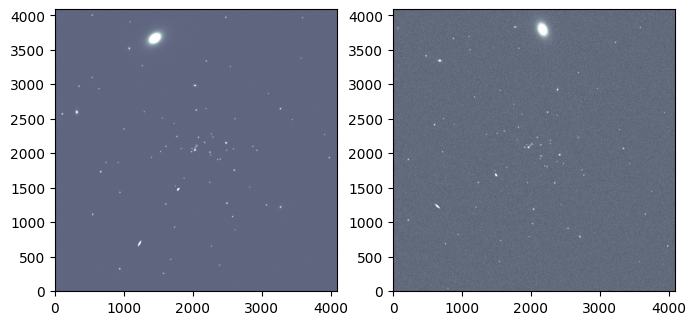

In [39]:
img_2 = fits.getdata(fits_file_2, ext=1)

fig_2, ax_2 = plt.subplots(1, 2, figsize=(8, 4))
ax_2[0].imshow(img_1, vmin=0.2, vmax=0.3, origin='lower', cmap='bone')
ax_2[1].imshow(img_2, vmin=0.2, vmax=0.3, origin='lower', cmap='bone')

### Add an Artifical Point Source to an Observation

With the STIPS `makePSF` utility, users can "clip" a PSF from a given detector pixel position in a scene and inject it elsewhere.

This is achieved by first applying a bi-linear interpolation of a 3x3 array from the STIPS PSF library to compute the best PSF at the specified integer SCA pixels, and then by performing bicubic interpolations over the PSF's supersampled pixel grid to fill out its sub-pixel positions. The resulting PSF can then be injected in an existing scene or used to create new scenes.

Use the `make_epsf_array()` method from STIPS' `AstroImage` class to create an example PSF from the library.

In [40]:
ai = AstroImage()

ai.detector = 'SCA01'
ai.filter = 'F129'
test_psf = ai.make_epsf_array()[0][0][0]

2025-12-11 19:39:48,003 INFO: WFI01: (RA, DEC, PA) := (0.0, 0.0, 0.0), detected as (0.0, 0.0, 0.0)


2025-12-11 19:39:48,008 INFO: PSF File psf_WFI_2.3_F129_sca01.fits to be put at /home/runner/psf_cache


2025-12-11 19:39:48,009 INFO: PSF File is /home/runner/psf_cache/psf_WFI_2.3_F129_sca01.fits


2025-12-11 19:39:48,220 INFO: WFI01: Starting 3x3 PSF Grid creation at Thu Dec 11 19:39:48 2025



Running instrument: WFI, filter: F129
  Running detector: WFI01
    Position 1/9: (0, 0) pixels


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (31.993143027288347, 0.015652222616090228)


    Position 1/9 centroid: (np.float64(87.68541919417059), np.float64(88.03481459910967))
    Position 2/9: (0, 2048) pixels


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (30.9911863199469, 2048.0151620285324)


    Position 2/9 centroid: (np.float64(87.63328382510608), np.float64(88.02733538122686))
    Position 3/9: (0, 4095) pixels


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


    Position 3/9 centroid: (np.float64(87.58301233203386), np.float64(88.01899212396057))
    Position 4/9: (2048, 0) pixels


    Position 4/9 centroid: (np.float64(87.69119843725669), np.float64(88.12253423286828))
    Position 5/9: (2048, 2048) pixels


    Position 5/9 centroid: (np.float64(87.63549224663767), np.float64(88.1306506582468))
    Position 6/9: (2048, 4095) pixels


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.0050174304056, 4074.4937619323296)


    Position 6/9 centroid: (np.float64(87.60856529394864), np.float64(88.16422780816005))
    Position 7/9: (4095, 0) pixels


    Position 7/9 centroid: (np.float64(87.69736545139544), np.float64(88.21119913102282))
    Position 8/9: (4095, 2048) pixels


    Position 8/9 centroid: (np.float64(87.66556138528847), np.float64(88.26217961693057))
    Position 9/9: (4095, 4095) pixels


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.004894881753, 4074.994618276213)


2025-12-11 19:40:40,925 INFO: WFI01: Finished PSF Grid creation at Thu Dec 11 19:40:40 2025


    Position 9/9 centroid: (np.float64(87.63478098231859), np.float64(88.3115054278644))
  Saving file: /home/runner/psf_cache/psf_WFI_2.3_F129_wfi01.fits


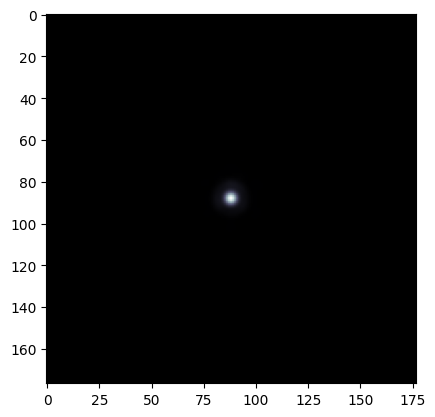

In [41]:
plt.imshow(test_psf, cmap='bone')

Specify the pixel coordinates of the source's center (which are just the center of the PSF in this case) and the pixel length of the intended cutout (1/8th of the full example PSF's pixel length).

In [42]:
psf_mid_pixel = (test_psf.shape[0] - 1) // 2
boxsize = test_psf.shape[0] // 8

Inject the source at pixel (2000, 2000) with an arbitrary flux of 3000 DN/sec in a copy of the simulated image from the second observation simulated above. Can you see the newly injected PSF in the comparison plot?

In [43]:
img_3 = img_2.copy()
xpix = 2000
ypix = 2000
flux = 3000

img_3_inj = stips.utilities.makePSF.place_source(xpix, ypix, flux, img_3,
                                                 test_psf, boxsize=boxsize,
                                                 psf_center=psf_mid_pixel)

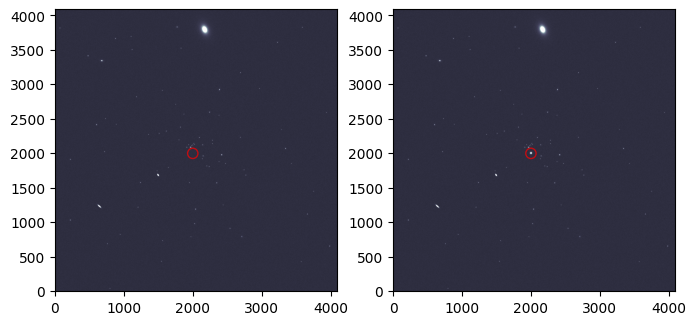

In [44]:
fig_3, ax_3 = plt.subplots(1, 2, figsize=(8, 4))
ax_3[0].imshow(img_2, vmin=0.15, vmax=0.6, origin='lower', cmap='bone')
ax_3[1].imshow(img_3_inj, vmin=0.15, vmax=0.6, origin='lower', cmap='bone')

for ax in ax_3:
    ax.add_patch(plt.Circle((xpix, ypix), 75, color='r', alpha=.7, fill=False))

## Additional Resources

- The Roman User Documentation's ["STIPS Overview"](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stips-space-telescope-imaging-product-simulator/overview-of-stips) page and associated tutorials.
- The latest version of the [STIPS documentation](https://stips.readthedocs.io/en/latest/) on ReadTheDocs.
- The [Roman Help Desk](https://roman-docs.stsci.edu/roman-help-desk-at-stsci), an official outlet for user questions about STIPS.

***

## About this Notebook

**Author:** Justin Otor, Eunkyu Han  
**Updated On:** 2025-01-08

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>